2022-12-30, (MA Period  5) Starting Value 10000.00
2018-03-16, BUY EXECUTED, Price: 141.30, Cost: 1413.00, Comm 1.41
2018-05-03, SELL EXECUTED, Price: 148.07, Cost: 1413.00, Comm 1.48
2018-08-07, BUY EXECUTED, Price: 146.44, Cost: 1464.40, Comm 1.46
2018-11-22, SELL EXECUTED, Price: 143.74, Cost: 1464.40, Comm 1.44
2019-03-18, BUY EXECUTED, Price: 154.30, Cost: 1543.00, Comm 1.54
2019-05-03, SELL EXECUTED, Price: 166.18, Cost: 1543.00, Comm 1.66
2019-08-06, BUY EXECUTED, Price: 163.98, Cost: 1639.80, Comm 1.64
2019-11-22, SELL EXECUTED, Price: 176.38, Cost: 1639.80, Comm 1.76
2020-03-16, BUY EXECUTED, Price: 112.87, Cost: 1128.70, Comm 1.13
2020-05-04, SELL EXECUTED, Price: 133.68, Cost: 1128.70, Comm 1.34
2020-08-04, BUY EXECUTED, Price: 157.04, Cost: 1570.40, Comm 1.57
2020-11-20, SELL EXECUTED, Price: 167.55, Cost: 1570.40, Comm 1.68
2021-03-16, BUY EXECUTED, Price: 184.39, Cost: 1843.90, Comm 1.84
2021-05-04, SELL EXECUTED, Price: 189.51, Cost: 1843.90, Comm 1.90
2021-08-06, BUY EX

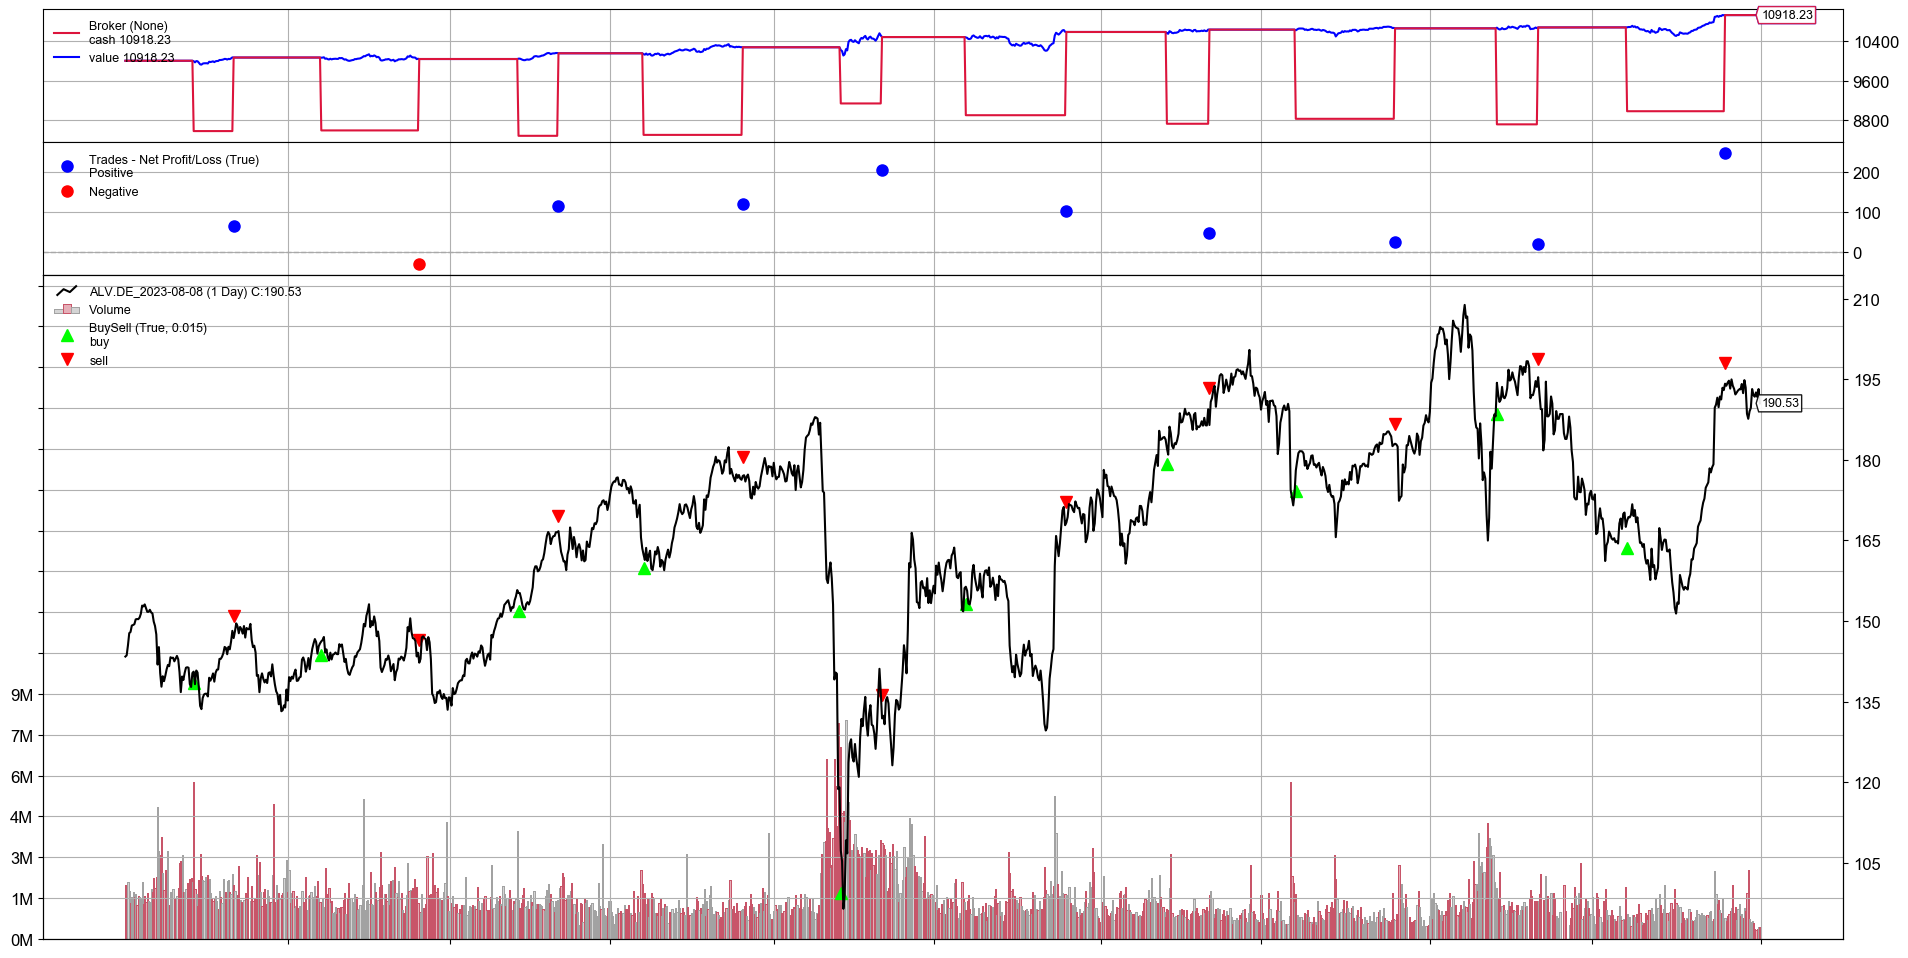

[[<Figure size 2000x1000 with 4 Axes>]]

In [35]:
%matplotlib inline

import datetime # For datetime objects
import os.path  # To manage paths
import datetime as dt
import pickle
from calendar import isleap

import matplotlib

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):

    params = (
        ('exitbars', 5),
        ('printlog', False),
        ('yearlyTradeDates', [
            { 'start': '05/08', 'end': '20/11' },
            { 'start': '15/03', 'end': '01/05' },
            ]),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # calc day of years for trading days
        self.tradeDays = []
        for yearlyTradeDate in self.params.yearlyTradeDates:
            self.tradeDays.append({
                'start': dt.datetime.strptime(f'{yearlyTradeDate["start"]}/2023', '%d/%m/%Y').timetuple().tm_yday,     # 2023 is no leap year
                'end': dt.datetime.strptime(f'{yearlyTradeDate["end"]}/2023', '%d/%m/%Y').timetuple().tm_yday          # 2023 is no leap year
                })

        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None

    # notification for each change of the status of each order
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm), doprint=True)
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm), doprint=True)
        
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    # notification of each actual trade    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    # notification for each iteration through data
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # claculate correction for leap years
        isLeapYearCorr = 1 if isleap(self.data.datetime.date().year) else 0  # remember counter of 1 for leap year and 0 for others
        dayOfYear = self.data.datetime.datetime().timetuple().tm_yday        # calc day of year of current day
        dayOfYear = dayOfYear + (isLeapYearCorr if dayOfYear > 59 else 0)    # if current day greater Feb. 28 add leap year counter

        # Check if we are not in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            for tradeDay in self.tradeDays:
                if tradeDay['start'] <= dayOfYear <= tradeDay['end']:

                    # BUY, BUY, BUY!!! (with default parameters)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()

                    # prevent buying again in overlapping ranges
                    break

        else:

            # Already in the market ... we might sell
            #if not self.params.yearlyTradeStartDate <= self.data.datetime.datetime() <= self.params.yearlyTradeEndDate:
            sellCounter = 0
            for tradeDay in self.tradeDays:
                if not tradeDay['start'] <= dayOfYear <= tradeDay['end']:
                    sellCounter += 1

                if sellCounter == len(self.tradeDays):
                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.sell()

    # notification before starting interation through data
    def start(self):
        self.val_start = self.broker.get_cash()  # keep the starting cash
        self.log('(MA Period %2d) Starting Value %.2f' % (self.params.exitbars, self.broker.getvalue()), doprint=True)

    # notification after final interation through data
    def stop(self):
        roi = (self.broker.get_value() / self.val_start) - 1.0
        self.log(f'(MA Period {(self.params.exitbars):2d}) Ending Value {(self.broker.getvalue()):.2f}, ROI: {(100.0 * roi):.2f}%', doprint=True)


# load info from analyzer
dirname = '.downloads'
pickleFilename = f"{dirname}{os.path.sep}lastAnalysis.pkl"
analyzerInfo = pickle.load(open(pickleFilename, 'rb'))

# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

# 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

# Create a Data Feed
data = bt.feeds.YahooFinanceCSVData(
    dataname=analyzerInfo['historyFilename'],
    # Do not pass values before this date
    fromdate=analyzerInfo['rangeMax5yrs'].min(),
    # Do not pass values after this date
    todate=analyzerInfo['rangeMax5yrs'].max(),
    # Do not pass values after this date
    reverse=False)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(10000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

# Run over everything
cerebro.run(maxcpus=1)

# fix font family issue
matplotlib.rcParams.update({
    'font.family':'sans-serif',
    'font.sans-serif':['Arial Unicode MS'],
    })

matplotlib.rcParams['figure.figsize'] = [20, 10]
matplotlib.rcParams.update({'font.size': 12}) 

# plot out the strategy
cerebro.plot(iplot=False)